In [342]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [343]:
# Importing dependencies
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from math import sqrt
import datetime as dt
import time
import yfinance as yf
plt.style.use('ggplot')

### Data Preprocessing

In [344]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

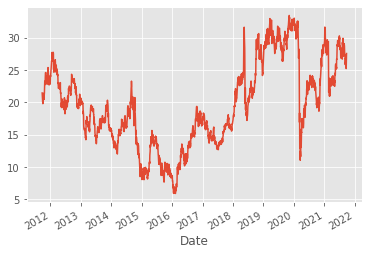

In [345]:
# Loading the dataset
p = '10y'
i = '1d'

df = yf.download(tickers='petr3.sa', period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot()

In [346]:
# Correlation matrix
df.corr()['Close']

Open         0.997818
High         0.998927
Low          0.999088
Close        1.000000
Adj Close    0.991137
Volume      -0.071804
Name: Close, dtype: float64

In [347]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df.shape

count    2.454000e+03
mean     1.356988e+07
std      1.281893e+07
min      1.610000e+04
25%      6.985425e+06
50%      1.046900e+07
75%      1.619740e+07
max      3.104194e+08
Name: Volume, dtype: float64


(2454, 6)

# Variáveis externas

In [348]:
def consulta_selic(ultimos):
  url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados/ultimos/{}?formato=json'.format(ultimos)
     #'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=01/01/2018'
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [349]:
def vwap(df):
    v = df['Volume'].values
    tp = (df['Low'] + df['Close'] + df['High']).div(3).values
    return df.assign(Vwap=(tp * v).cumsum() / v.cumsum())

In [350]:
# Dollar Brasileiro
df_dollar = yf.download(tickers=['USDBRL=x'], period = p, interval = i)
# SP500
df_sp500 = yf.download(tickers=['SPY'], period = p, interval = i)
# Ibovespa
df_ibov = yf.download(tickers=['^BVSP'], period = p, interval = i)
#Petroleo da China
df_ptr = yf.download(tickers=['PTR'], period = p, interval = i)
#Petroleo Brasil
df_pbr = yf.download(tickers=['PBR'], period = p, interval = i)
#Dow Jones Industrial
df_dji = yf.download(tickers=['^DJI'], period = p, interval = i)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [351]:
df_petr = yf.download(tickers='petr3.sa', period = p, interval = i)
df_petr.drop(df_petr[df_petr['Volume']==0].index, inplace = True)
print(df_petr.shape)
#Calculando VWAP
df_petr = vwap(df_petr)

# #Concatenando variáveis
df_temp = df_petr.rename(columns={"Adj Close": "Adj_close"})

#Dollar
temp = df_dollar['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Usdbrl"})

#sp500
temp = df_sp500['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Sp500"})

# #Dow Jones Industrial
temp = df_dji['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Dji"})

# #ibov
temp = df_ibov['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Ibov"})

# #Petroleo
temp = df_pbr['Adj Close']
df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
df_temp = df_temp.rename(columns={"Adj Close": "Pbr"})

# #Selic
# temp = df_selic['valor']
# df_temp = pd.concat([df_temp,temp.reindex(df_temp.index)],axis=1)
# df_temp = df_temp.rename(columns={"valor": "Selic"})

df_data = df_temp

df_data
print(df_data.shape)
df_data


[*********************100%***********************]  1 of 1 completed
(2454, 6)
(2454, 12)


,Open,High,Low,Close,Adj_close,Volume,Vwap,Usdbrl,Sp500,Dji,Ibov,Pbr
Date,,,,,,,,,,,,
2011-09-27,22.000000,22.129999,21.450001,21.459999,17.078527,2889000,21.680000,NaN,NaN,NaN,53920.0,NaN
2011-09-28,21.690001,21.700001,21.209999,21.209999,16.879572,4599400,21.491644,1.8020,94.803955,11010.900391,53270.0,19.135338
2011-09-29,21.450001,21.549999,21.110001,21.110001,16.799986,5027500,21.397256,1.8177,95.553246,11153.980469,53385.0,19.078018
2011-09-30,21.000000,21.219999,20.700001,20.900000,16.632862,6697400,21.237865,1.8277,93.165421,10913.379883,52324.0,18.382042
2011-10-03,20.760000,20.850000,20.059999,20.059999,15.964363,5822200,21.025184,1.8470,90.514130,10655.299805,50792.0,17.604183
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20,24.840000,25.240000,24.500000,25.230000,25.230000,20098700,19.154182,5.2897,434.040009,33970.468750,108844.0,9.520000
2021-09-21,25.480000,25.840000,25.160000,25.629999,25.629999,11818300,19.156452,5.3232,433.630005,33919.839844,110250.0,9.710000
2021-09-22,25.940001,26.740000,25.940001,26.459999,26.459999,12562500,19.159180,5.2689,437.859985,34258.320312,112282.0,9.980000


In [352]:
df_data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj_close     0
Volume        0
Vwap          0
Usdbrl       27
Sp500        62
Dji          62
Ibov          1
Pbr          62
dtype: int64

In [353]:
#Imputando dados baseado na média 20
df_data['Usdbrl'] = df_data['Usdbrl'].fillna(df_data['Usdbrl'].rolling(30,min_periods=1).mean())
df_data['Sp500'] = df_data['Sp500'].fillna(df_data['Sp500'].rolling(30,min_periods=1).mean())
df_data['Dji'] = df_data['Dji'].fillna(df_data['Dji'].rolling(30,min_periods=1).mean())
df_data['Ibov'] = df_data['Ibov'].fillna(df_data['Ibov'].rolling(30,min_periods=1).mean())
df_data['Pbr'] = df_data['Pbr'].fillna(df_data['Pbr'].rolling(30,min_periods=1).mean())
#df_data['Selic'] = df_data['Selic'].fillna(df_data['Selic'].rolling(30,min_periods=1).mean())

print(df_data.isnull().sum())
df_data.dropna(inplace=True)
print(df_data.isnull().sum())
df = df_data

Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       1
Sp500        1
Dji          1
Ibov         0
Pbr          1
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj_close    0
Volume       0
Vwap         0
Usdbrl       0
Sp500        0
Dji          0
Ibov         0
Pbr          0
dtype: int64


In [354]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [355]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    
    X_train,Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [356]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [357]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [358]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [359]:
# Extracting the series
#features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Vwap', 'Usdbrl', 'Sp500', 'Ibov', 'Dji', 'Pbr']
#features = ['Close', 'Low', 'High', 'Usdbrl', 'Pbr']
features = ['Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2453, 4)
                Close       Open        Low       High
Date                                                  
2021-09-20  25.230000  24.840000  24.500000  25.240000
2021-09-21  25.629999  25.480000  25.160000  25.840000
2021-09-22  26.459999  25.940001  25.940001  26.740000
2021-09-23  27.559999  26.459999  26.459999  27.559999
2021-09-24  27.559999  27.350000  27.150000  27.840000


In [360]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1853, 4) (300, 4) (300, 4)


In [361]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1853, 4) (300, 4) (300, 4)


In [362]:
timesteps = 25
hl = [50,25]
lr = 1e-4
batch_size = 64
num_epochs = 200

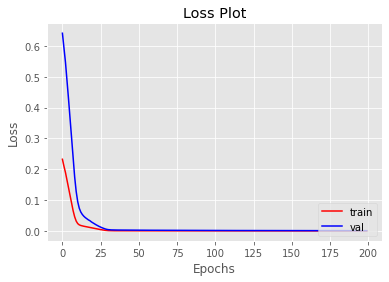

In [363]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.022379020950206406
MSE = 0.00104097082494107
RMSE = 0.03226407948386363
R2-Score = 0.929003976914933


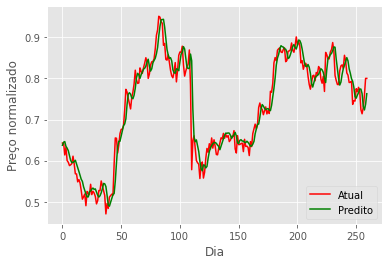

In [364]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,40)
print('MAE = {}'.format(mae))
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [365]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model
# Load a model
model = load_model('MV3-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [366]:
timesteps = 25
hl = [50,35]
lr = 1e-4
batch_size = 64
num_epochs = 50

In [367]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2453, 4)
                Close       Open        Low       High
Date                                                  
2021-09-20  25.230000  24.840000  24.500000  25.240000
2021-09-21  25.629999  25.480000  25.160000  25.840000
2021-09-22  26.459999  25.940001  25.940001  26.740000
2021-09-23  27.559999  26.459999  26.459999  27.559999
2021-09-24  27.559999  27.350000  27.150000  27.840000


In [368]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.55555551, 0.58281079, 0.5732202 , 0.56694336],
       [0.55192448, 0.57395798, 0.56953159, 0.56153009],
       [0.54429917, 0.55735891, 0.55440802, 0.54962104],
       ...,
       [0.74618731, 0.73957951, 0.74769463, 0.74882711],
       [0.78612923, 0.75876057, 0.76687569, 0.7784193 ],
       [0.78612923, 0.79158983, 0.79232758, 0.78852398]])

### Split I

In [369]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.016629263319888645
MSE = 0.0004120781614217117
RMSE = 0.02029970840730752
R-Squared Score = 0.9301997156918991


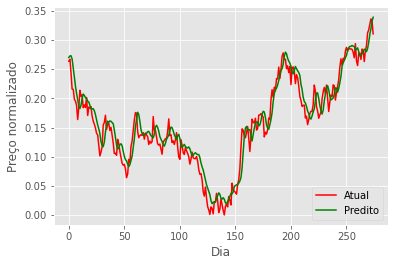

In [370]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split1.h5")

### Split II

Split 2
MAE = 0.011582681436874416
MSE = 0.0002534962262916354
RMSE = 0.015921564819188955
R-Squared Score = 0.9336176036524325


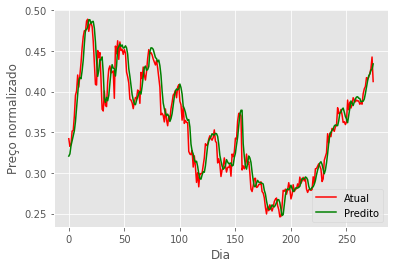

In [371]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split2.h5")

### Split III

Split 3
MAE = 0.020739424628056054
MSE = 0.0008394540265193887
RMSE = 0.028973333023996198
R-Squared Score = 0.956327367886806


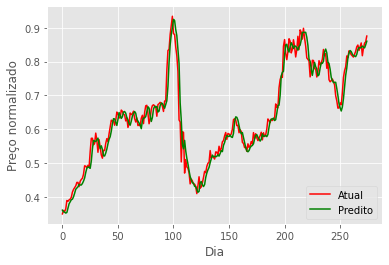

In [372]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split3.h5")

### Split IV

Split 4
MAE = 0.021348410654011968
MSE = 0.0011376717076656332
RMSE = 0.03372938937581932
R-Squared Score = 0.966983220099244


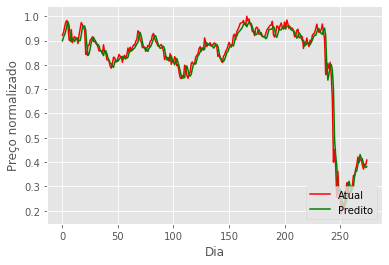

In [373]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split4.h5")

### Split V

Split 5
MAE = 0.018710296872927922
MSE = 0.0007298870709313221
RMSE = 0.02701642224520712
R-Squared Score = 0.9438146598594696


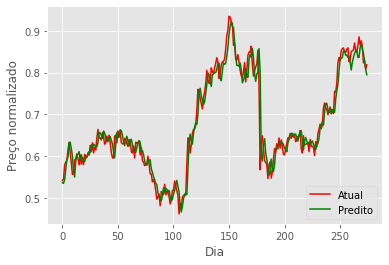

In [374]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-GRU-Split5.h5")

In [375]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.0178020153823518
Avg. MSE = 0.0006745174385659381
Avg. RMSE = 0.02518808357430382
Avg. R2-score = 0.9461885134379703


In [376]:
CV_results.to_csv('GRU-M PETR3.csv')
# train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
# val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')